In [1]:
from time import sleep
from datetime import timedelta
import multiprocessing
import functools

import boto3
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence

np.random.seed(42)
%matplotlib inline

In [2]:
imfinzi_data = pd.read_csv("../nsclc_stage3/no_surgery_decision_tree_models/ct_rt_no_surgery_merged_data.csv")

In [4]:
nscls_s3_df=pd.read_csv(f"s3://azai-proto-spark/sagemaker/6e64fbe2-08dc-45ed-9c37-bdab7b31c983.csv")

In [6]:
def clean_data(in_df):
    in_df["event"]=in_df["event"].apply(str.strip)
    in_df["date"]=pd.to_datetime(in_df["start_date"])  
    in_df.drop_duplicates(subset=['event','date','patient_id'],inplace=True)
    in_df=in_df[~in_df.event.isin(['stage3_radiation','stage3_chemotherapy'])]
    in_df["event_id"]=in_df["event"].apply(event_to_id.get)
    return in_df

In [5]:
#loading unique event to id mapping dictionary
with open('../sequence_modelling/final_event_to_id.pkl', 'rb') as fp:
    event_to_id = pickle.load(fp)

In [ ]:
imfinzi_data = clean_data(imfinzi_data)

In [8]:
imfinzi_data.head()

,Unnamed: 0,patient_id,tumor,category,event,start_date,date,event_id
0,1,1575205512,NSCLC,TEST,BLOOD_TEST,2012-07-24 00:00:00.000,2012-07-24,405
1,4,1387865306,OVARIAN,ER,ER,2017-04-12 00:00:00.000,2017-04-12,71
2,7,2221336081,MCL,DIAGNOSIS,DX_SECONDARY,2017-07-19 00:00:00.000,2017-07-19,185
3,8,2755441635,BLADDER,ER,ER,2017-03-22 00:00:00.000,2017-03-22,71
4,9,1260101179,NSCLC,ER,ER,2013-03-05 00:00:00.000,2013-03-05,71


In [9]:
imfinzi_pids = imfinzi_data[imfinzi_data["event"]=="IMFINZI"].patient_id.unique()
len(imfinzi_pids)

1775

In [10]:
imfinzi_df = imfinzi_data[imfinzi_data["patient_id"].isin(imfinzi_pids)]

In [11]:
non_imfinzi_df = imfinzi_data[~imfinzi_data["patient_id"].isin(imfinzi_pids)]

In [12]:
non_imfinzi_pids= non_imfinzi_df.patient_id.unique()

In [13]:
nscls_neg_df = nscls_s3_df[nscls_s3_df["patient_id"].isin(non_imfinzi_pids)]

In [15]:
def get_therapy_occ_dates_for_ct_rt(df):
    gb_pid_df=df.groupby("patient_id")
    therapy_occurence_dates={}
    for pid, frame in tqdm(gb_pid_df):
        sorted_frame=frame.sort_values(by="line_start_date")
        ct_dates=sorted_frame[sorted_frame.line_of_therapy=='CRT_CHEMOTHERAPY']["line_start_date"].values
        rt_dates=sorted_frame[sorted_frame.line_of_therapy=='CRT_RADIATION']["line_start_date"].values
        if ct_dates[0]>=rt_dates[0]:
            therapy_occurence_dates[pid]=ct_dates[0]     
        else:
            therapy_occurence_dates[pid]=rt_dates[0]
            
    return therapy_occurence_dates

In [16]:
neg_occurence_dates = get_therapy_occ_dates_for_ct_rt(nscls_neg_df)

100%|██████████| 40434/40434 [01:02<00:00, 648.58it/s]


#### Loading and Cleaning the Tagrisso Positive Data

#### Loading and cleaning Negative Data, Drop Duplicate Events

##### Split Tagrisso Positive and Negative Data into train and validation

In [17]:
np.random.seed(1)
np.random.shuffle(imfinzi_pids)

In [18]:
np.random.seed(1)
np.random.shuffle(non_imfinzi_pids)

In [19]:
len(non_imfinzi_pids)

40434

In [20]:
#taking 15k tagrisso patient-ids in training data and 6k patient-ids in validation data 
train_imfinzi_pids=imfinzi_pids[0:int(0.8*len(imfinzi_pids))]
validation_imfinzi_pids=imfinzi_pids[int(0.8*len(imfinzi_pids)):]

In [21]:
#taking 100k non-tagrisso patient-ids in training data and 31k patient-ids in validation data 
train_non_imfinzi_pids=non_imfinzi_pids[0:int(0.8*len(non_imfinzi_pids))]
validation_non_imfinzi_pids=non_imfinzi_pids[int(0.8*len(non_imfinzi_pids)):]

In [22]:
train_imfinzi_data=imfinzi_df[imfinzi_df.patient_id.isin(train_imfinzi_pids)]
validation_imfinzi_data=imfinzi_df[imfinzi_df.patient_id.isin(validation_imfinzi_pids)]

In [23]:
#split the data into train and validation
train_non_imfinzi_data=non_imfinzi_df[non_imfinzi_df.patient_id.isin(train_non_imfinzi_pids)]
validation_non_imfinzi_data=non_imfinzi_df[non_imfinzi_df.patient_id.isin(validation_non_imfinzi_pids)]

In [24]:
# returns a dictionary of the first occurence date  of tagrisso event for each patient
def gen_target_dates(df,event='IMFINZI'):
    target_dates={}
    groupby_df=df.groupby("patient_id")
    for pid,frame in groupby_df:
        sorted_frame=frame.sort_values(by='date',axis=0)
        target_event_frame = sorted_frame[sorted_frame['event']==event]
        target_date = target_event_frame['date'].iloc[0]
        target_dates[pid]=target_date
    return target_dates

In [25]:
train_imfinzi_occurence_dates = gen_target_dates(train_imfinzi_data)
validation_imfinzi_occurence_dates = gen_target_dates(validation_imfinzi_data)

In [125]:
def get_durations_for_sequences(data,target_dates = None,window=1):
    patient_durations={}
    data_groupby_pid=data.groupby("patient_id")
    for pid,frame in tqdm(data_groupby_pid):
        sorted_frame=frame.sort_values(by=["date","event_id"])
        if target_dates is not None:
            target_time=target_dates[pid]
            end_time=target_time-timedelta(days=window)
        else:
            target_time=pd.to_datetime(neg_occurence_dates[pid])
            last_date = sorted_frame.date.iloc[-1]
            tail_len = (last_date-target_time).days
            if tail_len>0:
                add_len= np.random.randint(0, min(548, tail_len))
            else: 
                add_len=0
            
            end_time=target_time+timedelta(days=add_len)
        event_df= sorted_frame[sorted_frame['date']<end_time]
        if len(event_df)>=128:
            duration = (event_df.date.iloc[-1]- event_df.date.iloc[-128]).days
        patient_durations[pid] = duration
            
    return patient_durations

In [129]:
pos_patient_durations = get_durations_for_sequences(imfinzi_df, gen_target_dates(imfinzi_df))
neg_patient_durations = get_durations_for_sequences(non_imfinzi_df)

100%|██████████| 40434/40434 [01:40<00:00, 403.31it/s]


In [154]:
ppda = np.array(list(pos_patient_durations.values()))
print(f"""Mean= {np.mean(ppda)}, Standard deviation = {np.std(ppda)},
Minimum value= {np.min(ppda)}, Maximum value= {np.max(ppda)}""")

Mean= 220.08845070422535, Standard deviation = 343.68604827968613,
Minimum value= 32, Maximum value= 3055


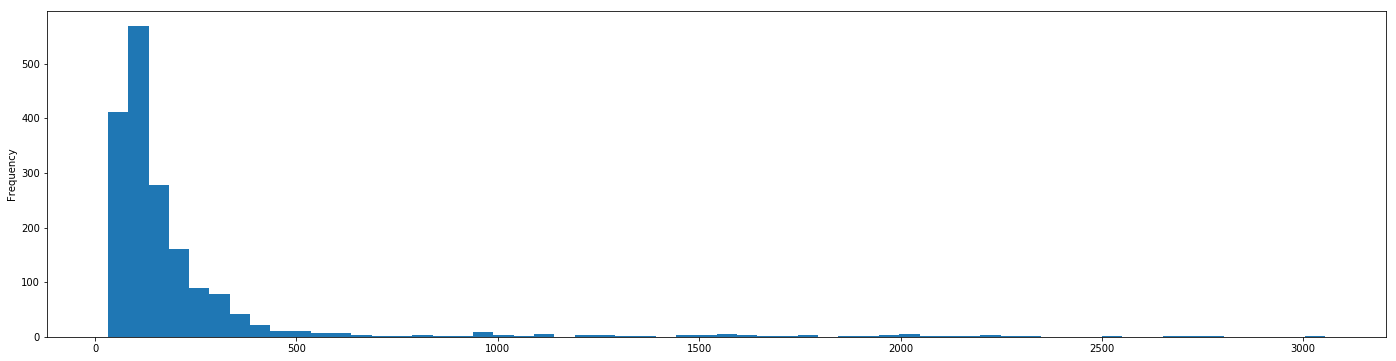

In [145]:
pd.Series(pos_patient_durations).plot(kind="hist", bins=60, figsize= (24,6))

In [153]:
npda = np.array(list(neg_patient_durations.values()))
print(f"""Mean= {np.mean(npda)}, Standard deviation = {np.std(npda)},
Minimum value= {np.min(npda)}, Maximum value= {np.max(npda)}""")

Mean= 316.84100014839, Standard deviation = 380.0435249969007,
Minimum value= 18, Maximum value= 4771


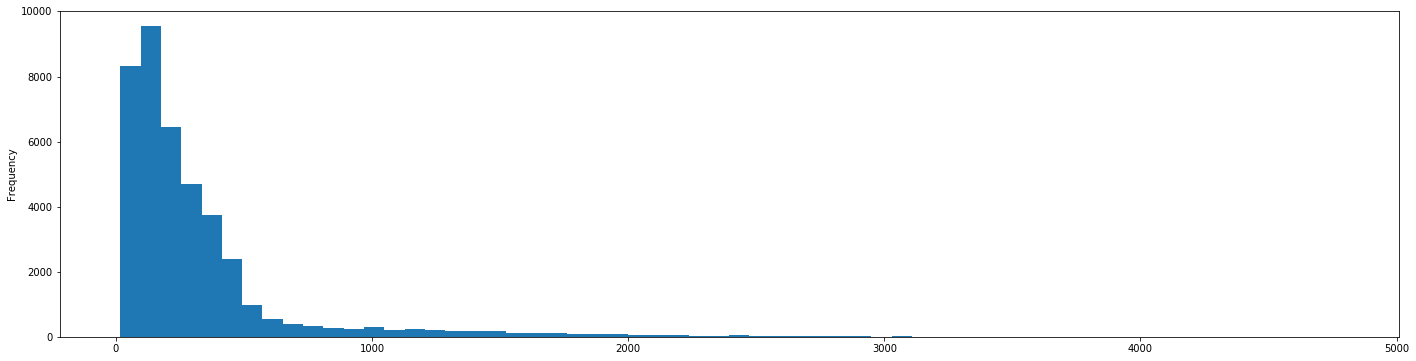

In [155]:
pd.Series(neg_patient_durations).plot(kind="hist", bins=60, figsize= (24,6))

In [26]:
# """generating the events for each patient at a day level b/w 6 months before the first occurence of tagrisso and 1-day 
#   before tagrsisso  for positive patients"""

# """generating the events for each patient at a day level in an interval of 6 months before the last 6 month journey  
#    for negative patients"""
def get_sequences_for_pids(data,target_dates = None,window=1):
    patient_events=[]
    data_groupby_pid=data.groupby("patient_id")
    for pid,frame in tqdm(data_groupby_pid):
        sorted_frame=frame.sort_values(by=["date","event_id"])
        if target_dates is not None:
            target_time=target_dates[pid]
            end_time=target_time-timedelta(days=window)
        else:
            target_time=pd.to_datetime(neg_occurence_dates[pid])
            last_date = sorted_frame.date.iloc[-1]
            tail_len = (last_date-target_time).days
            if tail_len>0:
                add_len= np.random.randint(0, min(548, tail_len))
            else: 
                add_len=0
            
            end_time=target_time+timedelta(days=add_len)
        event_df= sorted_frame[sorted_frame['date']<end_time]
        events=event_df.event_id.values
        patient_events.append(events)
            
    return np.array(patient_events)

In [27]:
train_imfinzi_dl_events = get_sequences_for_pids(train_imfinzi_data, 
                                                  target_dates= train_imfinzi_occurence_dates)
validation_imfinzi_dl_events = get_sequences_for_pids(validation_imfinzi_data, 
                                                       target_dates = validation_imfinzi_occurence_dates)

100%|██████████| 355/355 [00:00<00:00, 476.52it/s]


In [28]:
train_non_imfinzi_dl_events = get_sequences_for_pids(train_non_imfinzi_data)
validation_non_imfinzi_dl_events = get_sequences_for_pids(validation_non_imfinzi_data)

100%|██████████| 8087/8087 [00:19<00:00, 422.47it/s]


In [29]:
print(len(train_non_imfinzi_dl_events), len(validation_non_imfinzi_dl_events))
len(train_imfinzi_dl_events), len(validation_imfinzi_dl_events)

32347 8087


(1420, 355)

In [30]:
#getting non-overlapping 10 day-level-event sequences given a day-level-event aggregate patient journey 
def get_sequences(sequences,ts=10):
    final_seq=[]
    for pid_sequnces in sequences:
        len_seq=len(pid_sequnces)
        if len_seq>=128:
            seq=pid_sequnces[-ts:]
            final_seq.append(np.array(seq))
    return final_seq

In [31]:
SEQ_LENGTH = 128

In [32]:
train_positive_events=get_sequences(train_imfinzi_dl_events, ts=SEQ_LENGTH)
validation_positive_events=get_sequences(validation_imfinzi_dl_events, ts=SEQ_LENGTH)
print(len(train_positive_events),len(validation_positive_events))

1317 334


In [33]:
train_negative_events=get_sequences(train_non_imfinzi_dl_events, ts=SEQ_LENGTH)
validation_negative_events=get_sequences(validation_non_imfinzi_dl_events, ts=SEQ_LENGTH)
print(len(train_negative_events),len(validation_negative_events))

26044 6467


In [34]:
#assign labels for tagrisso positive and tagrisso negative patients as 1's and 0's (train_data)
X_train=train_positive_events+train_negative_events
y_train=[1]*len(train_positive_events)+[0]*len(train_negative_events)

In [35]:
#assign labels for tagrisso positive and tagrisso negative patients as 1's and 0's (validation_data)
X_test = validation_positive_events+validation_negative_events

In [36]:
y_test = [1]*len(validation_positive_events)+[0]*len(validation_negative_events)

In [37]:
#shuffle the train and validation sequences
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0, random_state=42)

In [38]:
y_train=np.array(y_train)
y_test=np.array(y_test)

In [39]:
X_train =  np.array(X_train)
X_test = np.array(X_test)

In [52]:
len(y_train), len(y_test)

(27361, 6801)

In [41]:
if tf.test.is_gpu_available():
    rnn = tf.keras.layers.CuDNNGRU
else:
    rnn = functools.partial(
        tf.keras.layers.GRU, recurrent_activation='sigmoid')

In [42]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, hidden_states):
        score = tf.nn.tanh(self.W1(hidden_states))#[bs,10,32]
        attention_weights = tf.nn.softmax(self.V(score), axis=1)#[bs,10,1]
        encoded_vector = attention_weights * hidden_states#[bs,10,32]
        encoded_vector = tf.reduce_sum(encoded_vector, axis=1)#[bs,32]
        return encoded_vector, attention_weights

In [43]:
def build_model(units,time_steps,drop_out=0.1):
    input_sequences = tf.keras.layers.Input(shape=(time_steps,),name='main_input')
    embed_sequences = tf.keras.layers.Embedding(len(event_to_id.keys()), 32, input_length=time_steps)(input_sequences)
    reduced_dim=tf.keras.layers.Dense(16)(embed_sequences)
    gru_out=tf.keras.layers.GRU(units,return_sequences=True,name="gru_unit")(reduced_dim)
    gru_out=tf.keras.layers.Dropout(drop_out)(gru_out)
    gru_out=tf.keras.layers.BatchNormalization()(gru_out)
    encoded_vector, attention_weights =Attention(units)(gru_out)
    ctg_out=tf.keras.layers.Dense(1,activation="sigmoid",name='ctg_out')(encoded_vector)
    model = tf.keras.Model(inputs=input_sequences, outputs=ctg_out)
    return model

In [ ]:
model=build_model(32,SEQ_LENGTH)

In [45]:
model.compile("adam",loss='binary_crossentropy',metrics=['accuracy'])

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 128)               0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 32)           15872     
_________________________________________________________________
dense (Dense)                (None, 128, 16)           528       
_________________________________________________________________
gru_unit (GRU)               (None, 128, 32)           4704      
_________________________________________________________________
dropout (Dropout)            (None, 128, 32)           0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 128, 32)           128       
_________________________________________________________________
attention (Attention)        [(None, 32), (None, 128,  1089      
__________

In [48]:
model.fit(x=X_train,y=y_train,batch_size=64,validation_data=(X_test,y_test),epochs=20, class_weight={0:1, 1:2})

Train on 27361 samples, validate on 6801 samples
Epoch 1/20
27361/27361 [==============================] - 28s 1ms/sample - loss: 0.2198 - acc: 0.9498 - val_loss: 0.1696 - val_acc: 0.9454
Epoch 2/20
27361/27361 [==============================] - 28s 1ms/sample - loss: 0.2169 - acc: 0.9503 - val_loss: 0.1681 - val_acc: 0.9462
Epoch 3/20
27361/27361 [==============================] - 28s 1ms/sample - loss: 0.2138 - acc: 0.9495 - val_loss: 0.1606 - val_acc: 0.9468
Epoch 4/20
27361/27361 [==============================] - 28s 1ms/sample - loss: 0.2102 - acc: 0.9504 - val_loss: 0.1604 - val_acc: 0.9469
Epoch 5/20
27361/27361 [==============================] - 28s 1ms/sample - loss: 0.2091 - acc: 0.9507 - val_loss: 0.1665 - val_acc: 0.9466
Epoch 6/20
27361/27361 [==============================] - 28s 1ms/sample - loss: 0.2068 - acc: 0.9499 - val_loss: 0.1931 - val_acc: 0.9338
Epoch 7/20
27361/27361 [==============================] - 28s 1ms/sample - loss: 0.2064 - acc: 0.9502 - val_loss: 0.1

In [49]:
y_pred=model.predict(X_test)

In [50]:
y_pred = y_pred.flatten()

Text(33.0, 0.5, 'Original class')

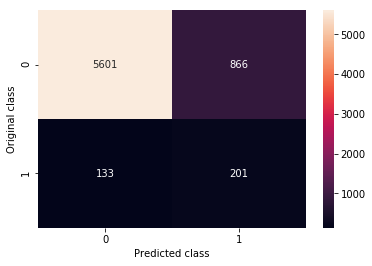

In [51]:
#thresholding at 10% (predicted_prob >10% is a positive class)
y_predicted=y_pred.flatten()
y_predicted_binaries=y_predicted.copy()
y_predicted_binaries[y_predicted_binaries>=0.10]=1
y_predicted_binaries[y_predicted_binaries<0.10]=0
sns.heatmap(metrics.confusion_matrix(y_test,y_predicted_binaries),annot=True, fmt="0.0f")
plt.xlabel("Predicted class")
plt.ylabel("Original class")

In [53]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_predicted)
print("acc-score {}".format(metrics.auc(fpr, tpr)))

acc-score 0.8393657250212734


In [54]:
precision, recall, threshold = metrics.precision_recall_curve(y_test,y_predicted)

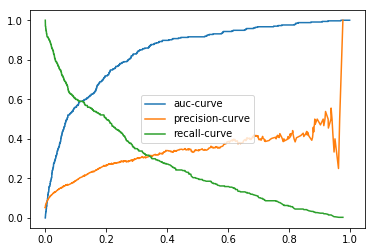

In [55]:
plt.plot(fpr, tpr)
plt.plot(threshold,precision[:-1])
plt.plot(threshold,recall[:-1])
plt.legend(("auc-curve","precision-curve","recall-curve"))

#### Loading the Attention Graph

In [56]:
att_model_output = model.layers[0:-1]
att_model = tf.keras.Model(att_model_output[0].input, att_model_output[-1].output)
att_model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])

In [57]:
att_model.predict(np.array([X_test[0]]))
np.array([X_test[0]]).shape

(1, 128)

In [58]:
h_model = model.layers[0:-2]
h_model = tf.keras.Model(h_model[0].input, h_model[-1].output)
h_model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])

In [59]:
id_to_event= {v: k for k, v in event_to_id.items()}

In [85]:
def map_attention(idx,att_model=att_model,hm= h_model, X_test=X_test):
    day_level_events=[]
    x_events=X_test[idx].reshape(-1,)
    model_input=np.array([X_test[idx]])
    attention_weights=att_model.predict(model_input)[1][0,:,0]
    
    # making the intensities 2X 
    max_weight = attention_weights.max()
    attention_weights = attention_weights*2
    attention_weights[attention_weights>=max_weight] = max_weight
    
    hidden_states = hm.predict(model_input)[0]
    pbt=model.predict(model_input)[0][0]
    y_actual=y_test[idx]
    
    x_events = [id_to_event[event] for event in x_events]
#     for events_set in x_events:
#         events=[]
#         for event in events_set:
#             events.append(id_to_event[event])
#         day_level_events.append(events)
    
#     day_level_events = [' ,'.join(v) for v in day_level_events]
    plot_df = pd.DataFrame()
    plot_df["Attention weight"] = attention_weights
    plot_df.index = x_events

    return plot_df, hidden_states

In [61]:
def get_distances(hidden_states):
    dists = [0]
    for i in range(1,len(hidden_states)):
        dists.append(np.linalg.norm(hidden_states[i-1]-hidden_states[i]))
    return dists

In [74]:
def plot_only_attention(idx):
    plot_df, _ = map_attention(idx)
    
    fig = plt.figure()
    fig.set_size_inches(8, 32)
    fig.tight_layout()
    plt.title(f'True_label = {y_test[idx]} \n Confidence for IMFINZI = {y_pred.flatten()[idx]}', fontsize=18)
    #fig.suptitle(f"Patient id in X_test {idx} \n True_label = {y_test[idx]} \n confidence = {y_pred.flatten()[idx]}")
    sns.heatmap(plot_df, cmap="YlGnBu")

In [162]:
def plot_attended_info(idx):
    plot_df, hidden_states = map_attention(idx)
    
    distances = get_distances(hidden_states)
    hidden_df = pd.DataFrame()
    hidden_df["distances"] = distances
    hidden_df.index = plot_df.index

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(18, 32)
    fig.suptitle(f'True_label = {y_test[idx]} \n Confidence for IMFINZI = {y_pred.flatten()[idx]}', fontsize=18)
    #plt.title(f'True_label = {y_test[idx]} \n Confidence for IMFINZI = {y_pred.flatten()[idx]}', fontsize=18)
    ax[0].set_title("Relative attention weights", fontsize=16)
    ax[1].set_title("The change in hidden state at each step", fontsize=16)
    
    ax[0]= sns.heatmap(plot_df, cmap="YlGnBu", ax=ax[0])
    ax[1]= sns.heatmap(hidden_df, cmap="YlGnBu", ax=ax[1])

In [164]:
def plot_only_hidden(idx):
    plot_df , hidden_states = map_attention(idx)
    
    distances = get_distances(hidden_states)
    hidden_df = pd.DataFrame()
    hidden_df["distances"] = distances
    hidden_df.index = plot_df.index

    fig = plt.figure()
    fig.set_size_inches(8, 32)
    fig.tight_layout()
    plt.title(f'True_label = {y_test[idx]} \n Confidence for IMFINZI = {y_pred.flatten()[idx]}', fontsize=18)
    #fig.suptitle(f"Patient id in X_test {idx} \n True_label = {y_test[idx]} \n confidence = {y_pred.flatten()[idx]}")
    sns.heatmap(hidden_df, cmap="YlGnBu")

In [66]:
THRESHOLD = 0.10
y_predicted_b=y_pred.copy()
y_predicted_b[y_predicted_b>=THRESHOLD]=1
y_predicted_b[y_predicted_b<THRESHOLD]=0

In [67]:
tps = np.arange(len(y_test))[(y_predicted_b==1) & (y_test==1)]
fps = np.arange(len(y_test))[(y_predicted_b==1) & (y_test==0)]
tns = np.arange(len(y_test))[(y_predicted_b==0) & (y_test==0)]
fns = np.arange(len(y_test))[(y_predicted_b==0) & (y_test==1)]
len(tps), len(fps), len(tns), len(fns)

(201, 866, 5601, 133)

In [90]:
def get_sorted_points(points):
    values = y_pred[points]
    indices = np.argsort(values)[::-1]
    return points[indices]

In [93]:
tps_sorted = get_sorted_points(tps)
fps_sorted = get_sorted_points(fps)
tns_sorted = get_sorted_points(tns)[::-1]
fns_sorted = get_sorted_points(fns)[::-1]

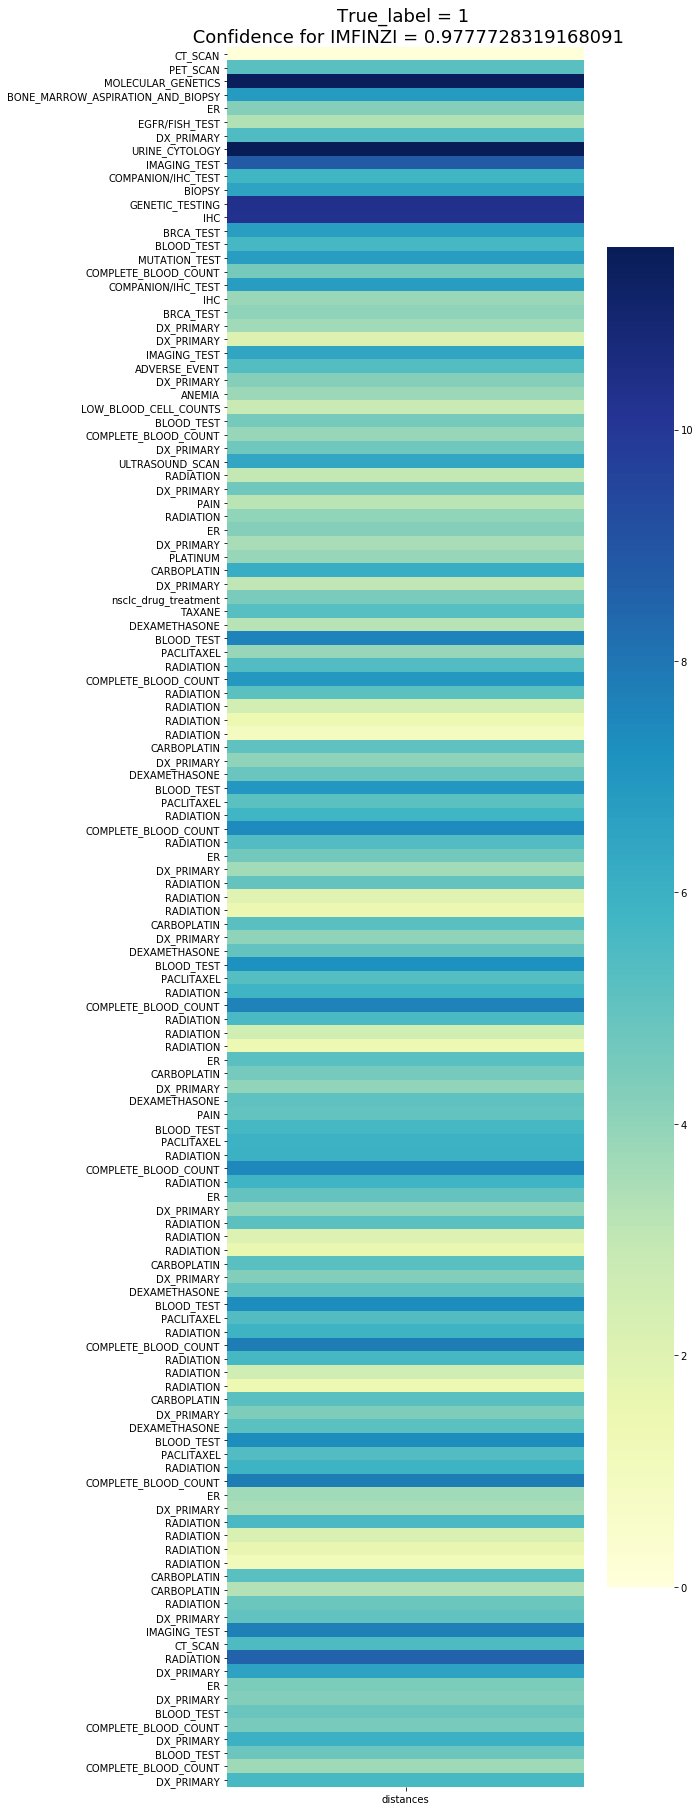

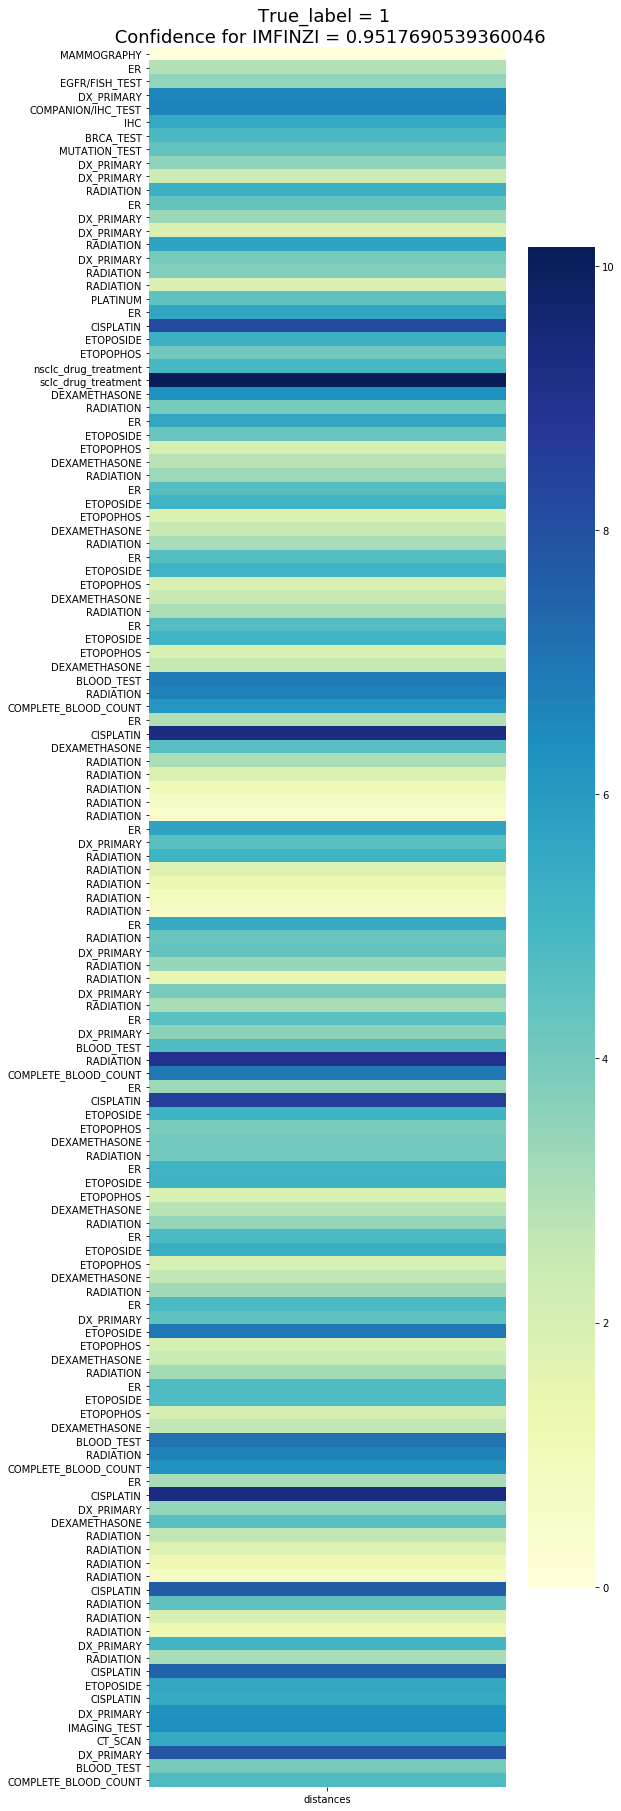

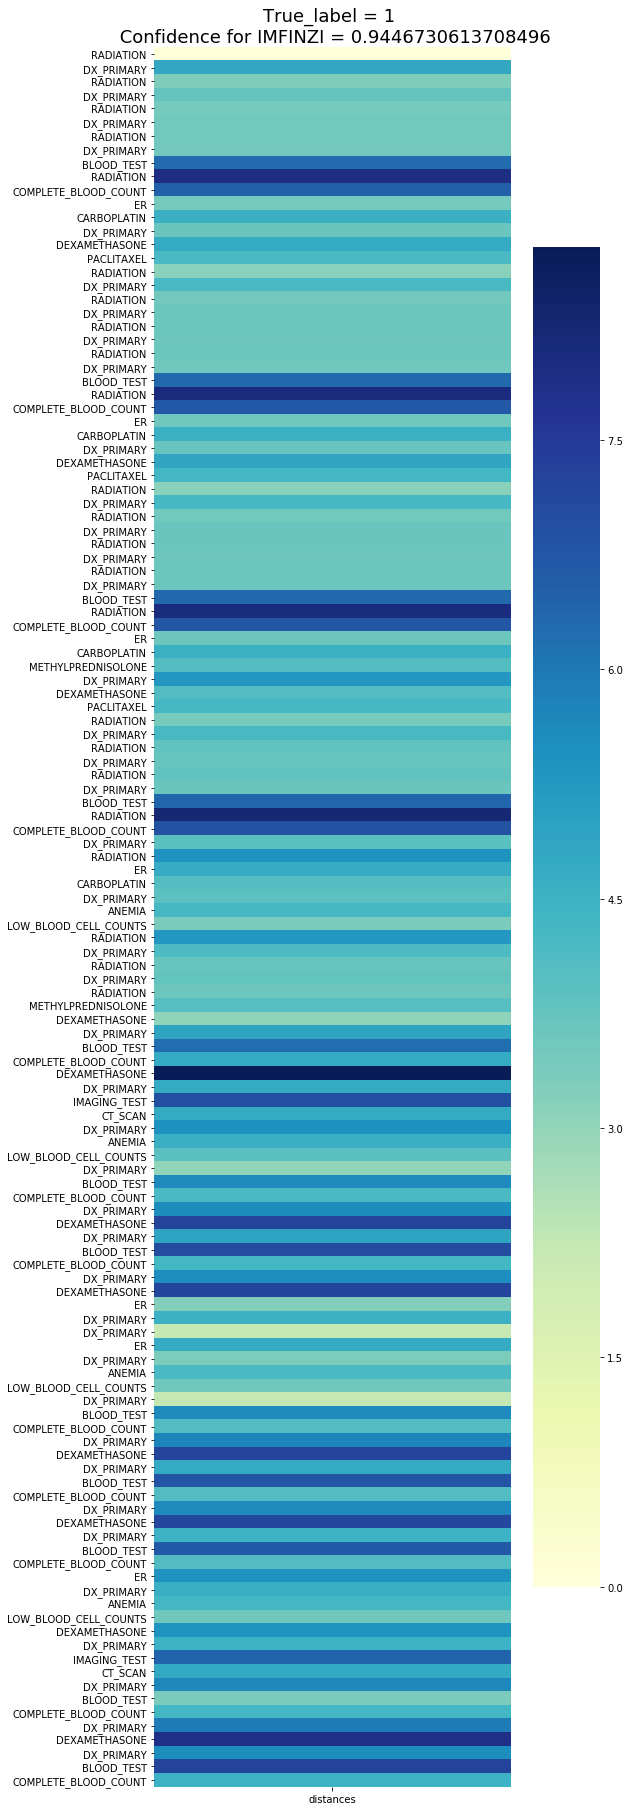

In [165]:
#True positives at threshold= 0.1
for idx in tps_sorted[:3]:
    #print(f"Patient id in X_test {idx} \n True_label = {y_test[idx]} \n confidence = {y_pred.flatten()[idx]} \n ")
    plot_only_hidden(idx)

In [ ]:
"""
OPDIVO - OPDIVO® (nivolumab) is a prescription medicine used to treat people with a type of advanced stage lung cancer (called non-small cell lung cancer) 
that has spread or grown and you have tried chemotherapy that contains platinum, and it did not work or is no longer working. 
If your tumor has an abnormal EGFR or ALK gene, you should have also tried an
FDA-approved therapy for tumors with these abnormal genes, and it did not work or is no longer working.

AVASTIN - Avastin, in combination with carboplatin and paclitaxel, is indicated for the first‑line treatment of patients 
with unresectable, locally advanced, recurrent or metastatic non–squamous non–small cell lung cancer.

ETOPOSIDE - Etoposide, sold under the brand name Etopophos among others, is a chemotherapy medication used for the treatments of a number of types of cancer. 
This includes testicular cancer, lung cancer, lymphoma, leukemia, neuroblastoma, and ovarian cancer.[1] It is used by mouth or injection into a vein.

TARCEVA - Tarceva is prescribed for patients with non-small cell lung cancer (NSCLC) whose cancer has spread 
to other parts of the body and that has certain types of epidermal growth factor receptor (EGFR) mutations.
While taking Tarceva, rash could happen or get worse if the skin is exposed to the sun. 
You may want to use alcohol-free lotions and sunscreens or avoid being out in the sun
"""

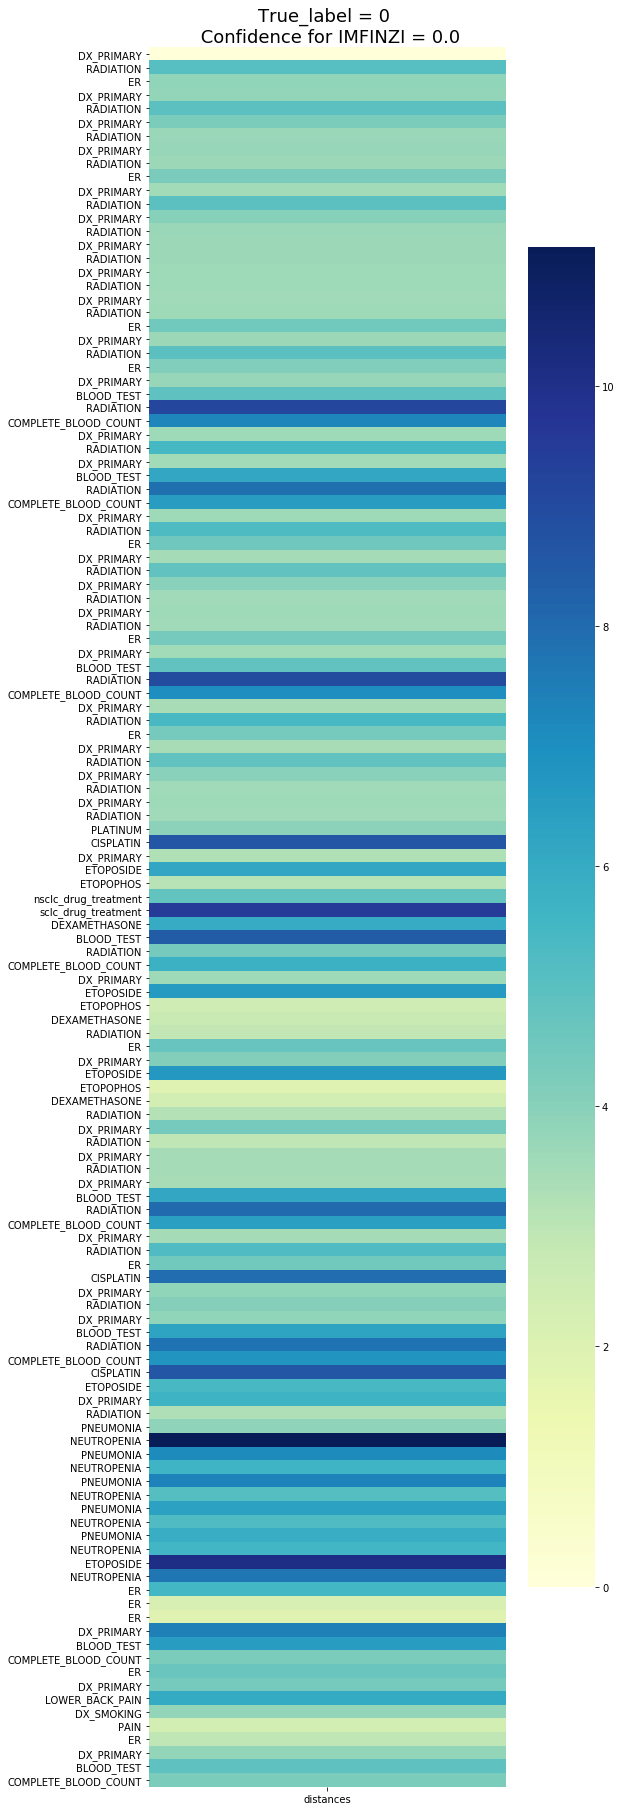

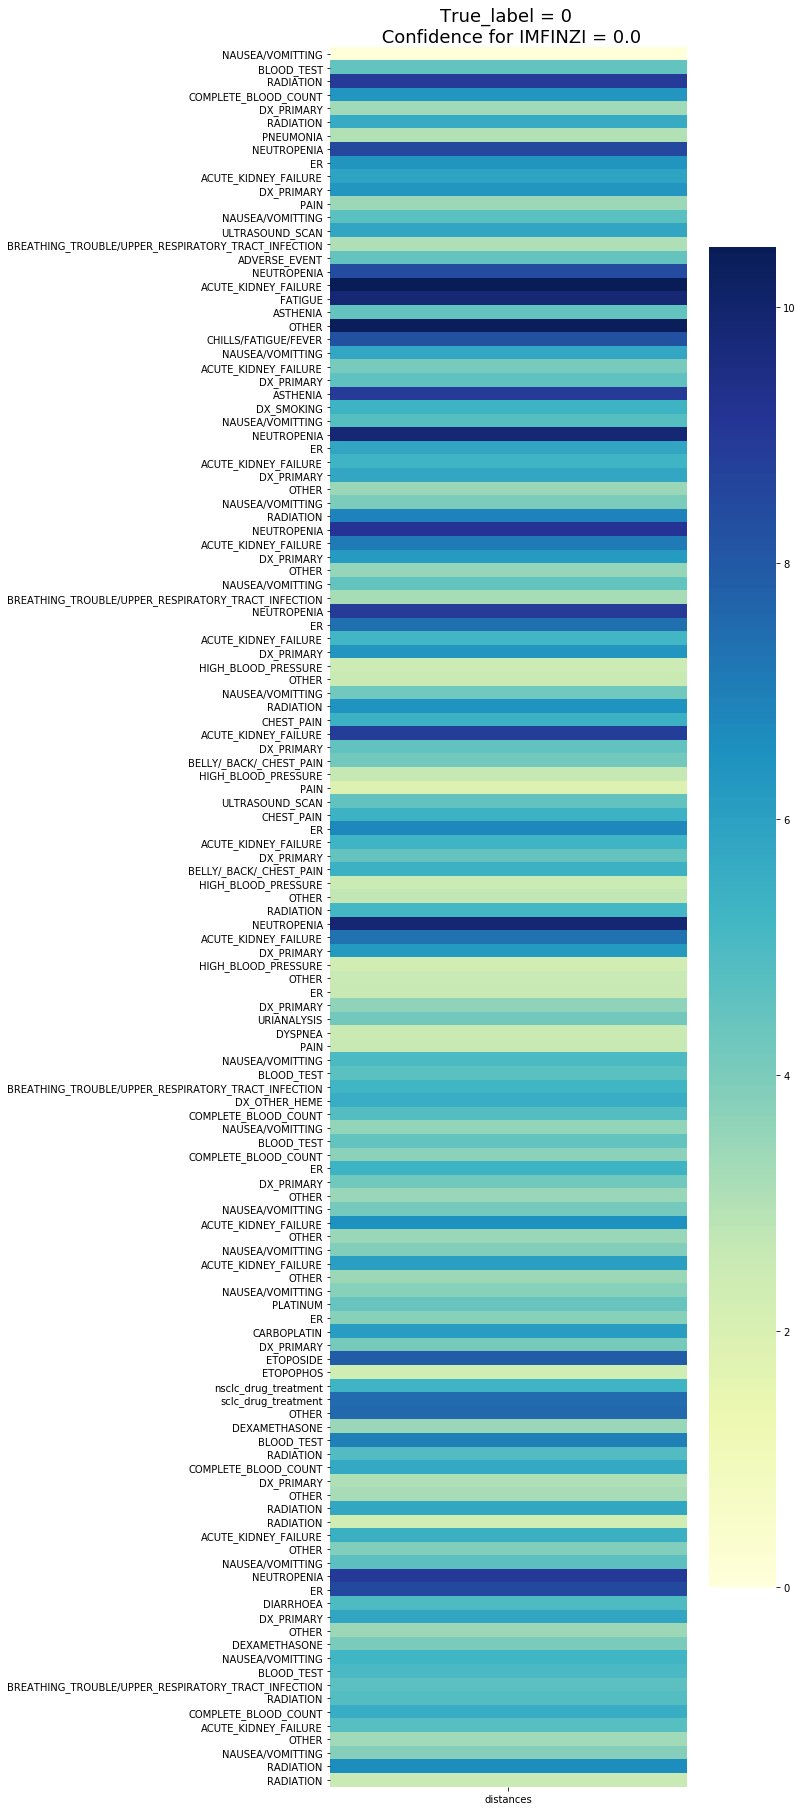

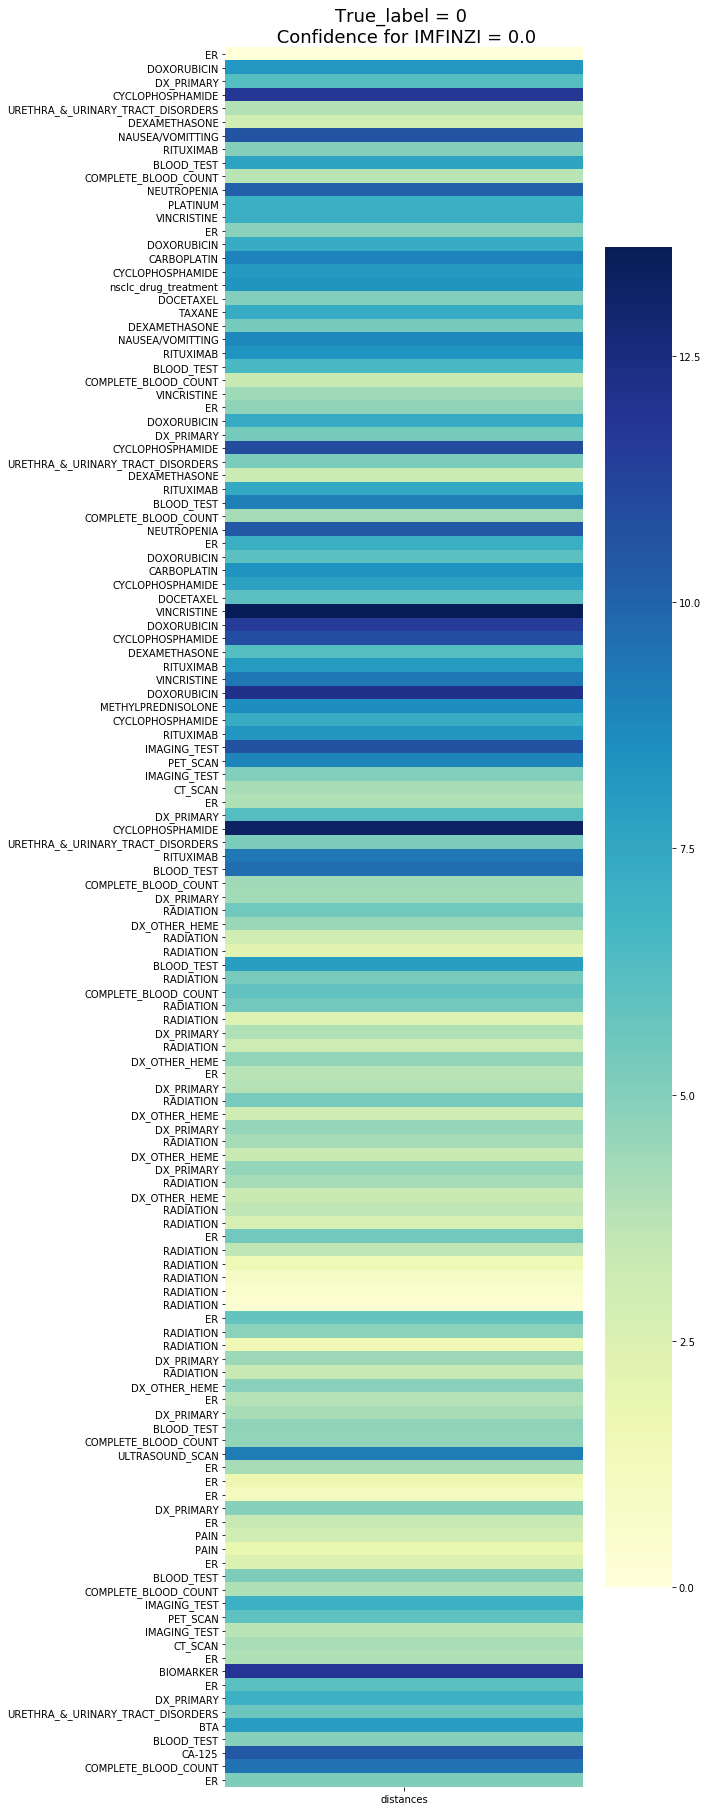

In [166]:
#true negatives at threshold=0.1
for idx in tns_sorted[:3]:
    #print(f"Patient id in X_test {idx} \n True_label = {y_test[idx]} \n confidence = {y_pred.flatten()[idx]} \n ")
    plot_only_hidden(idx)